In [2]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [3]:
import sys
sys.path.append("../dnn_from_scratch")

In [4]:
from matplotlib.image import imread
import cv2

In [5]:
DATA_DIR="/home/archer/machine_learning/Celeb100k/100k"
with open(DATA_DIR+".txt","r") as f:
    names=f.read().split('\n')[:-1]

In [6]:
def get_batch(st,btsz):
    X_train=[]
    for ii in names[st:st+btsz]:
        img=imread(DATA_DIR+"/"+ii)
        img=cv2.resize(img, dsize=(28,28))#, interpolation=cv2.INTER_CUBIC)
        X_train.append(img/255*2-1)
    return np.asarray(X_train)

In [7]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 248
Seed: 254


In [11]:
def generator():
    model=Sequential()
    model.add(dense(128*7*7,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((7,7,128)))
#     model.add(upsampling())
#     model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(upsampling())
#     model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(conv2d(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 12544)              leakyRelu        1266944
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 256)          echo             0
__________________________________________________________________________________________
3 conv2dtranspose(conv2dt (None, 14, 14, 256)        leakyRelu        590080
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 14, 14, 256)        echo             1024
__________________________________________________________________________________________
5 

In [12]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu,input_shape=(28,28,3)))
    model.add(max_pool())
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.2))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 3)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 28, 28, 32)         leakyRelu        896
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 28, 28, 32)         echo             128
__________________________________________________________________________________________
3 dropout(dropout)        (None, 28, 28, 32)         echo             0
__________________________________________________________________________________________
4 max_pool(max_pool)      (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
5 conv2d(con

In [13]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [14]:
svdnoise=np.random.randn(64,100).astype(np.float32)
gen=g.predict(svdnoise)

In [15]:
def gen_sample():
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])
    gen=g.predict(svdnoise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])

In [16]:
ccu=0

In [13]:
def run():
    global ccu
    batch_size=64
    dsz=len(names)
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=get_batch(ccu,batch_size)
        ccu+=batch_size
        # Train discriminator
#         y_fake=np.random.uniform(0,0.05,(batch_size,1)).astype(np.float32)
#         y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%20:
            gen_sample()
        print("\rProgress: {:.2f} %    {}    Dloss: {}    err: {}    Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,ccu,dloss,err.sum(),time()-stt),end='')

EPOCH: 1 / 2


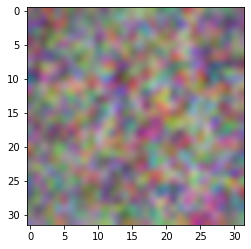

[1.]


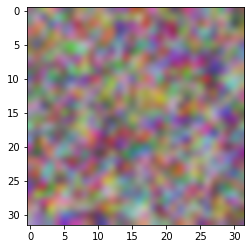

[1.]
Progress: 1.22 %    1280    Dloss: 51.56023406982422    err: -2.33488130569458    Sample time: 2.624s    _  _

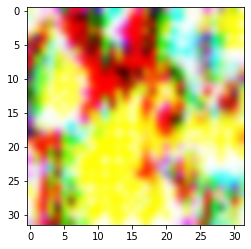

[0.80991656]


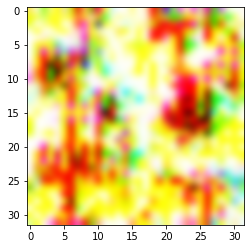

[0.9526855]
Progress: 2.50 %    2560    Dloss: 48.897361755371094    err: -0.9955084919929504    Sample time: 2.586s    _ _

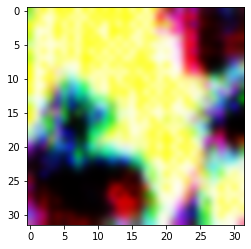

[0.1007783]


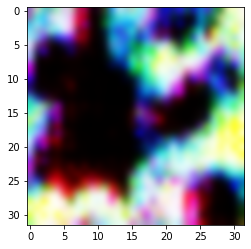

[0.8603715]
Progress: 3.78 %    3840    Dloss: 49.83340835571289    err: 0.8743652105331421    Sample time: 2.607s    ___

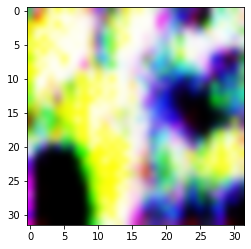

[0.04242113]


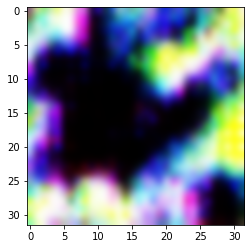

[0.32562342]
Progress: 5.06 %    5120    Dloss: 47.59548568725586    err: -1.4116296768188477    Sample time: 2.606s    __

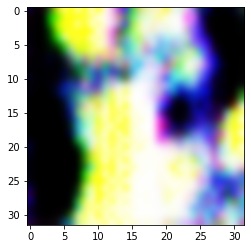

[0.49372494]


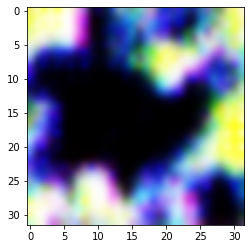

[0.38740924]
Progress: 6.34 %    6400    Dloss: 43.917083740234375    err: 0.3558531105518341    Sample time: 4.069s    __

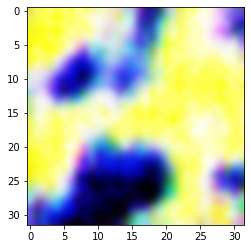

[0.08641843]


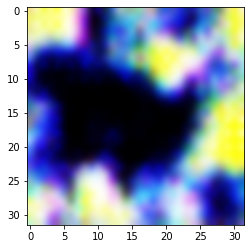

[0.23493709]
Progress: 7.62 %    7680    Dloss: 48.53276443481445    err: -0.6918128132820129    Sample time: 3.751s    _ _

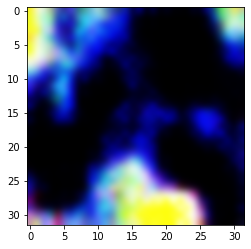

[0.60132647]


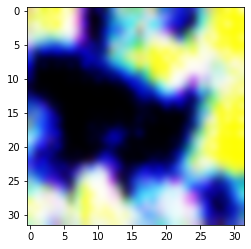

[0.8065897]
Progress: 8.90 %    8960    Dloss: 48.29219055175781    err: 0.05062288045883179    Sample time: 2.754s    __

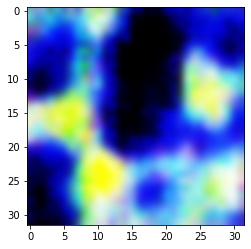

[0.18015274]


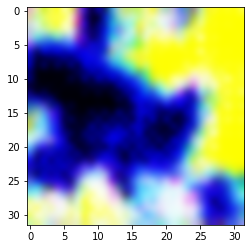

[0.35428068]
Progress: 10.18 %    10240    Dloss: 47.315738677978516    err: -0.16520637273788452    Sample time: 2.621s    _

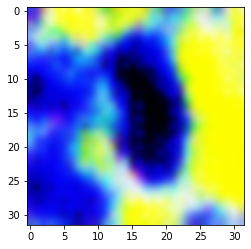

[0.35888]


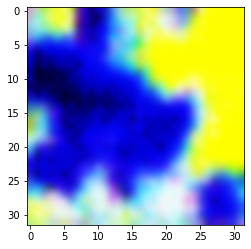

[0.4024928]
Progress: 11.46 %    11520    Dloss: 44.041770935058594    err: 1.3206217288970947    Sample time: 4.364s    __

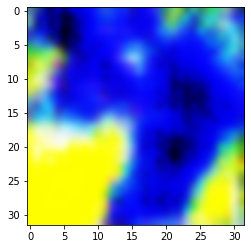

[0.49994063]


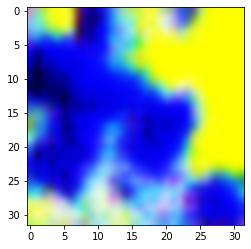

[0.87043154]
Progress: 12.74 %    12800    Dloss: 50.661949157714844    err: 1.6211984157562256    Sample time: 4.973s    __

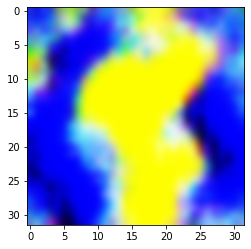

[0.68290424]


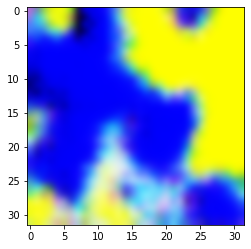

[0.68516326]
Progress: 12.80 %    12864    Dloss: 48.07760238647461    err: -1.2573521137237549    Sample time: 7.987s    _

KeyboardInterrupt: 

In [16]:
epochs=2
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

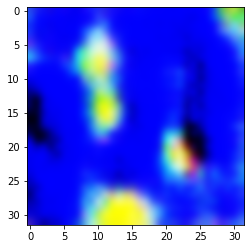

[0.14277065]


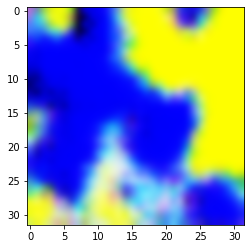

[0.66647667]


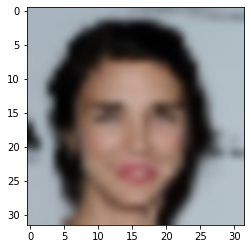

[[0.53382516]]


In [17]:
noise=np.random.randn(32,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=get_batch(np.random.randint(low=0,high=len(names)),1)
plt.imshow((img[0]+1)/2,interpolation='bicubic')
plt.show()
print(d.predict(img))

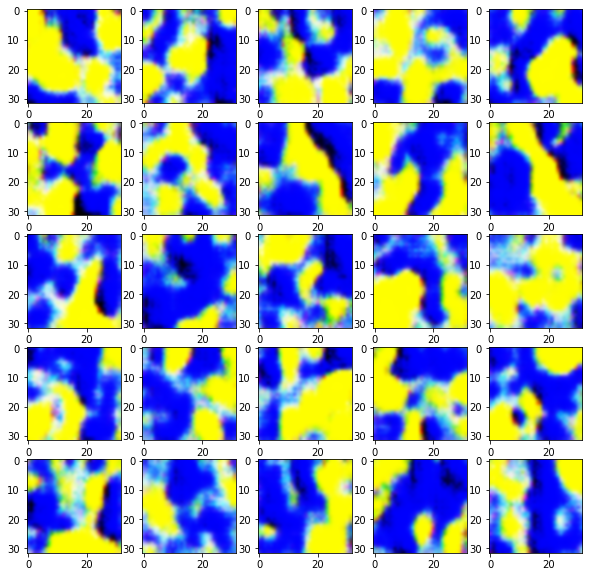

In [18]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow((gen[i].squeeze()+1)/2,interpolation='bicubic')